#  Predicting Titanic passenger survival with MCMC

This notebook intends to show the application of probabilisitic programming to the Titanic dataset from Kaggle. In particular it shows the implementation of an artificial neural network in PyMC3

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import seaborn

import pymc3 as pm
import theano.tensor as T
import theano

## I. Preparatory steps: Reading and cleaning

In [2]:
path_ = "/choose/your/path"

In [3]:
df = pd.read_csv(path_+'train.csv')

Check what the data look like:

In [4]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's see shape of dataframe, features of dataset as well as number of NaN's for each column

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We have ~20% of NaN. Let's replace the NaN with the mean of the non-missing rows.

In [6]:
meanAge = round(df.Age.mean(skipna=True),0)
df['Age'] = df['Age'].fillna(meanAge) 

To keep things simple we choose a reduced set of features...

In [7]:
features = ['Pclass','Sex','Age','Fare','Survived']
df = df[features]

... and create dummy variables out of them after turning the categorical *Pclass* variable into string type.

In [8]:
df.Pclass = df.Pclass.astype(str)
df = pd.get_dummies(df)

Notice what the effect of the last command. We have turn the original *Pclass* and *Sex* columns into two and three numerical columns, respectively: *Pclass_1*, *Pclass_2*, *Pclass_3* and *Sex_female*, *Sex_male*

In [9]:
df.columns

Index([u'Age', u'Fare', u'Survived', u'Pclass_1', u'Pclass_2', u'Pclass_3',
       u'Sex_female', u'Sex_male'],
      dtype='object')

In [10]:
df.head(5)

,Age,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,7.2500,0,0.0,0.0,1.0,0.0,1.0
1,38.0,71.2833,1,1.0,0.0,0.0,1.0,0.0
2,26.0,7.9250,1,0.0,0.0,1.0,1.0,0.0
3,35.0,53.1000,1,1.0,0.0,0.0,1.0,0.0
4,35.0,8.0500,0,0.0,0.0,1.0,0.0,1.0


## II. Visualization: Heatmap

Let's get the correlation matrix corresponding to our dataframe in order to visualize a heatmap 

In [11]:
corrMatr = df.corr()

In [12]:
corrMatr

,Age,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
Age,1.000000,0.090632,-0.070657,0.319120,0.004949,-0.278983,-0.084660,0.084660
Fare,0.090632,1.000000,0.257307,0.591711,-0.118557,-0.413333,0.182333,-0.182333
Survived,-0.070657,0.257307,1.000000,0.285904,0.093349,-0.322308,0.543351,-0.543351
Pclass_1,0.319120,0.591711,0.285904,1.000000,-0.288585,-0.626738,0.098013,-0.098013
Pclass_2,0.004949,-0.118557,0.093349,-0.288585,1.000000,-0.565210,0.064746,-0.064746
Pclass_3,-0.278983,-0.413333,-0.322308,-0.626738,-0.565210,1.000000,-0.137143,0.137143
Sex_female,-0.084660,0.182333,0.543351,0.098013,0.064746,-0.137143,1.000000,-1.000000
Sex_male,0.084660,-0.182333,-0.543351,-0.098013,-0.064746,0.137143,-1.000000,1.000000


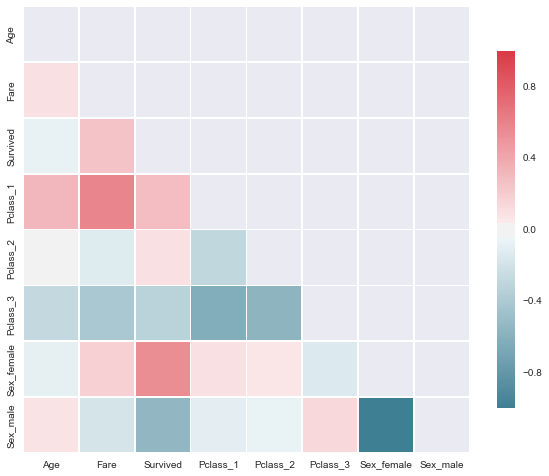

In [13]:
# We consider mask for upper triangle
mask = np.zeros_like(corrMatr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw heatmap with mask and correct aspect ratio
seaborn.heatmap(corrMatr, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.8, cbar_kws={"shrink": .8}, ax=ax)

## III. The model: An artifical neural net

Time to build our model. Let's try, just for the fun of it, a Bayesian Neural Network with one hidden layer. 

![](NN_5Units.jpg)

Since we will be adding a bias in our model let's add a column of ones to our current data frame.

In [14]:
df['Bias'] = np.ones(df.shape[0])

From our data frame we extract the corresponding matrix of fetures as well as the target

In [15]:
features = list(df.columns)
features.remove('Survived')
Xvalues = df[features].values
yvalues = df.Survived.values

We proceed with a typical split into test and training sets

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

In [17]:
X_train, X_test, y_train, y_test = \
train_test_split(Xvalues, yvalues, train_size=0.7,random_state=2016)

Turn inputs and outputs into shared variables so that we can change them later

In [18]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)
n_Neuron = 5 # number of units for hidden neural network

The following cell contains the actual implementation of the model. Some comments have been added in order to make the explanation as clear as possible. Remember that the main idea in probabilistic programming is to begin with a *prior probabilistic distribution* and imporve upon it as we gather information about observations.

In [19]:
# Initialize random weights for input and output
init_1 = np.random.randn(X_train.shape[1], n_Neuron)

init_out = np.random.randn(n_Neuron)

with pm.Model() as neural_network_01:
    # Weights from input to hidden layer with Normal distribution
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X_train.shape[1], n_Neuron), 
                             testval=init_1)
    
    # Weights from hidden layer to output with Normal distribution
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_Neuron,), 
                              testval=init_out)
    
    # Let's build neural-network with tanh activation functions...
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
 
       
    act_out = T.nnet.sigmoid(T.dot(act_1, weights_2_out))
    
    
    # Set output with a Bernoulli distribution
    out = pm.Bernoulli('out', act_out,observed=ann_output)

Now that we have built up the model is time to execute the *probabilistic program*. Be patient, this can take some time.

In [20]:
with neural_network_01:    

    # This time we use Metropolis-Hasting ...
    step = pm.Metropolis()
    
    # ... but you could also use a No-U-Turn Sampler
    #step = pm.NUTS()
    
    start = pm.find_MAP()
    
    trace_ANN_01 = pm.sample(20000, step=step, start=start,  progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 12.0 sec

Time to do some plotting of the model parameters. In hope that our calculation has already converged, let's plot the last 1000 samples. 

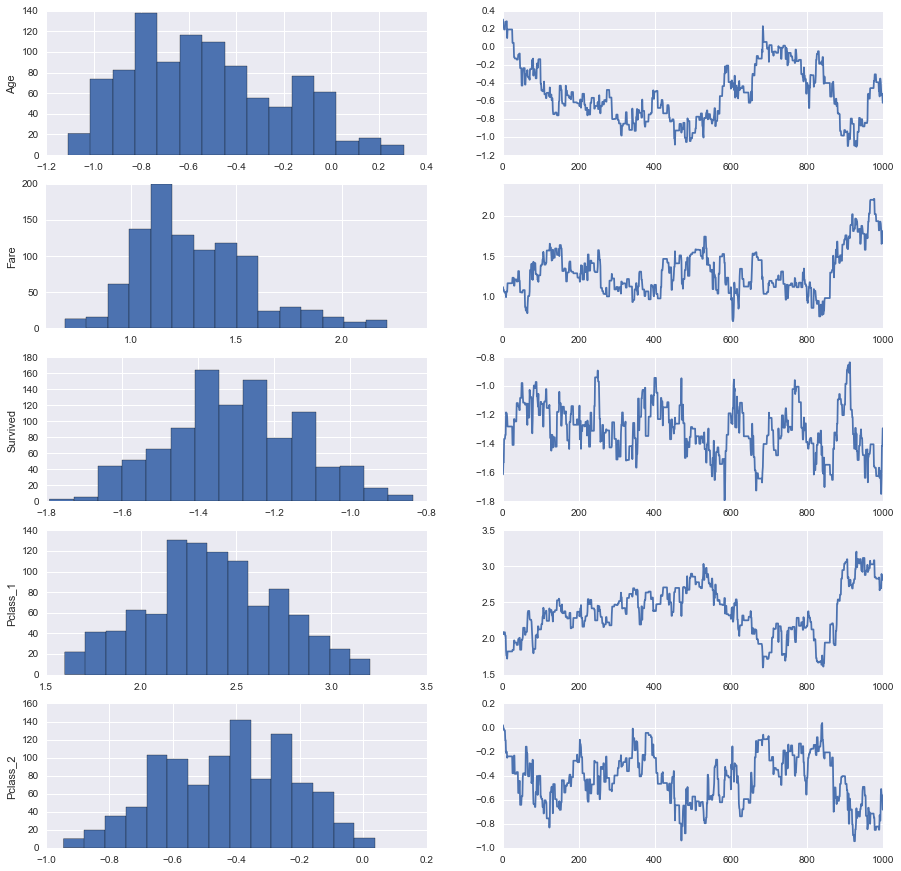

In [21]:
num_samples_plot = 1000
params_ANN_01 = trace_ANN_01["w_2_out"][-num_samples_plot:]
plt.figure(figsize=(15,15))
nb_plots = params_ANN_01.shape[1]
bins=15
for i in range(nb_plots):
    plt.subplot(nb_plots, 2, i*2+2) 
    plt.plot(range(params_ANN_01.shape[0]), params_ANN_01[:,i])
    plt.subplot(nb_plots, 2, i*2+1)
    plt.hist(params_ANN_01[:,i], bins=bins)
    plt.ylabel(df.columns[i])

The previous cell show the distribution of the parameters and their values in the last 1000 samples. It looks like we are not converged yet. Since the intention of this notebook is to show only the basics, let's proceed anyhow to see how we perform in our predictions. For this purpose we choose a threshold of  0.50  for our classifier.

In [22]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
# Create posterior predictive samples
ppc = pm.sample_ppc(trace_ANN_01, model=neural_network_01, samples=500)
# We set threshold to be 0.5
pred = ppc['out'].mean(axis=0) > 0.5
pred = 1*pred

Let's see some meassures of accuracy. We compute the typical accuracy and the area under the curve (AUC) for the Receiver operating characteristic (ROC) in addition.

In [23]:
print('Accuracy = {}'.format((y_test == pred).mean() ))
print('ROC-AUC = {}'.format(roc_auc_score(y_test,pred)))

Accuracy = 0.794776119403
ROC-AUC = 0.769087635054
